### 任务要求

以上project任选一个，组队形式提交源代码(Github repo地址)、训练模型、实验报告。详细的实验报告包括实验设置：数据集介绍，训练测试集划分，网络结构，batch size，learning rate，优化器，iteration，epoch，loss function，评价指标，结果可视化、tensorboard训练loss曲线、测试AP/Acc 曲线等等。

In [ ]:
#装载云盘
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g62uHONtHxOkNepZhkD9UvtpBWBCYhxdSbmAnaeqfrKkLOE8FLV65Y
Mounted at /content/drive


相比于LeNet，AlexNet有了以下进步：
1. Data Augmentation：主要有水平翻转，随机裁剪、平移变换，颜色、光照变化。

2. 使用了Relu激活函数

3. 使用了Dropout正则机制

4. LRN（临近数据的归一化）

5. overlapping Pooling。其实就是带有stride移动（非默认）的pooling

6. 多GPU（本次实现中未用）——不设置实验



对于模型的的计算，绘制training，lossfunction

In [ ]:
import pandas as pd
import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch 
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from matplotlib import pyplot as plt
#from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

#### 对transform的图像进行可视化

In [ ]:
from skimage import img_as_ubyte
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
transform = transforms.Compose([ transforms.ToTensor()])
test_dataset = datasets.CIFAR10( 'cifar',train=False, download=True,transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
# 得到一个随机的训练图片
dataiter = iter(test_loader)
for i in range(10):
  
  images, labels = dataiter.next()
  transform=transforms.Compose([transforms.Resize((224,224))])
  images_new=transform(images)
  images = torch.squeeze(images) 
  images = torch.transpose(images, 0, -1) 
  img = images.numpy() 
  img = img_as_ubyte(img) # 这点很重要！！这些数值都不是在0-255，所以要转换为unit8
  cv2.imwrite("/content/drive/MyDrive/cv_pj/transform_224/image%d.jpg"%i, img) # 保存为test.jpg
  #cv2_imshow(img)
  cv2.waitKey(0)

  images_new = torch.squeeze(images_new) 
  images_new = torch.transpose(images_new, 0, -1) 
  images_new = images_new.numpy() 
  images_new = img_as_ubyte(images_new) # 这点很重要！！这些数值都不是在0-255，所以要转换为unit8
  cv2.imwrite("/content/drive/MyDrive/cv_pj/transform_224/image_224_%d.jpg"%i, images_new) # 保存为test.jpg
  #cv2_imshow(images_new)
  cv2.waitKey(0)

print( "over.")


Extracting cifar/cifar-10-python.tar.gz to cifar
over.


#### 对数据集增强方式可视化


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


            cat             cat             cat           plane             car             cat            frog            frog


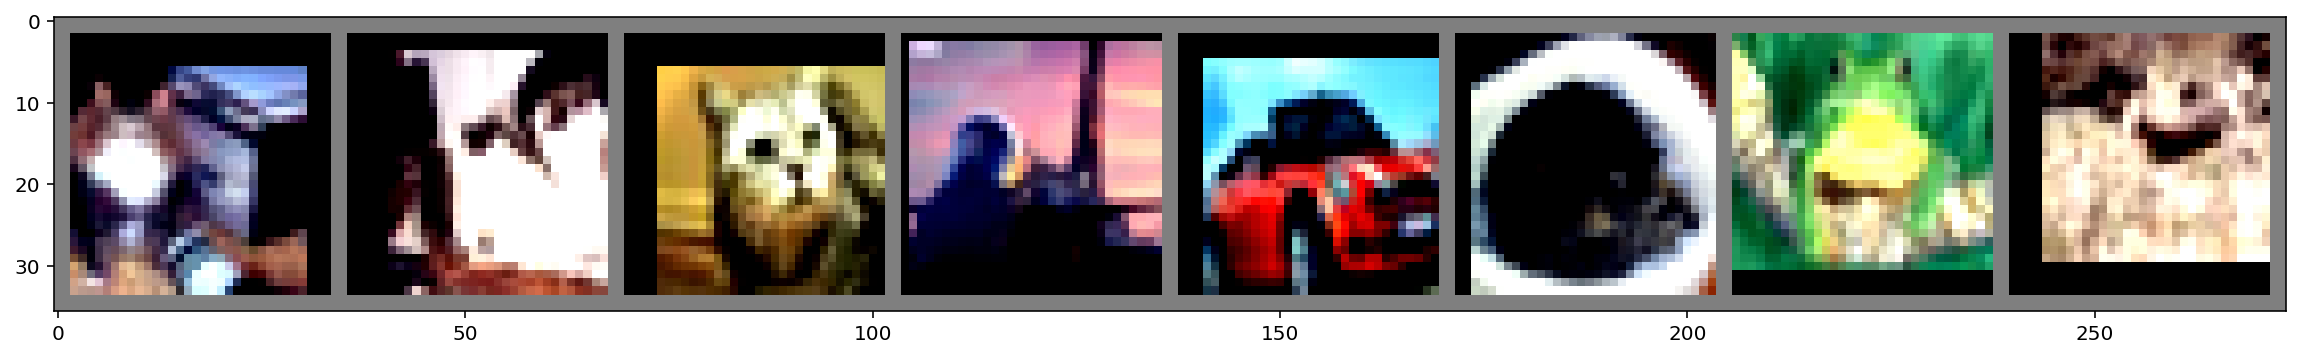

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


normalize = transforms.Normalize(mean=[0.49139968, 0.48215827, 0.44653124],
                                     std=[0.24703233, 0.24348505, 0.26158768])

train_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='cifar', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=50, shuffle=True,
        num_workers=4, pin_memory=True)

dev_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='cifar', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=50, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))


### 实验0

#### 原Alexnet

**对数据集进行resize，不改写alexnet**

参数设置：
batch_size=128

model:alexnet

lr=0.001

criterion = nn.CrossEntropyLoss(size_average=True)

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epoch=90

In [ ]:
#其实就是等比放大了图像，但是可能有利于大的kernel捕捉图像信息
batch_size = 128
cifar_train = datasets.CIFAR10('cifar', True, transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]), download=True)
train_dataloader = DataLoader(cifar_train,batch_size=batch_size,shuffle=True)
cifar_test = datasets.CIFAR10('cifar', False, transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]), download=True)
dev_dataloader= DataLoader(cifar_test,batch_size=batch_size,shuffle=False)  

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 10) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
unchanged_trainingloss=[]
unchanged_valloss=[]
unchanged_valacc=[]
unchanged_valacc5=[]

In [ ]:
import time
epoch=90
best_accuracy=0.0
es=0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    unchanged_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    unchanged_valloss.append(total_loss/steps)
    unchanged_valacc.append(total_correct/total_data_num) 
    unchanged_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es = 0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp0_unchanged/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp0_unchanged/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.150088
Epoch 0_51.200%:  Training average Loss: 2.058592
Epoch 0_76.800%:  Training average Loss: 1.964320
Epoch 0 :  Verification average Loss: 1.511271, Verification accuracy: 44.160000%,Total Time:119.266798
Epoch 0 :  Verification 5 accuracy: 91.390000%,Total Time:119.266923
Model is saved in /content/drive/MyDrive/cv_pj/exp0_unchanged/epoch_0_accuracy_0.441600
Epoch 1_25.600%:  Training average Loss: 1.572599
Epoch 1_51.200%:  Training average Loss: 1.532690
Epoch 1_76.800%:  Training average Loss: 1.502261
Epoch 1 :  Verification average Loss: 1.328019, Verification accuracy: 52.030000%,Total Time:238.586932
Epoch 1 :  Verification 5 accuracy: 93.570000%,Total Time:238.587045
Model is saved in /content/drive/MyDrive/cv_pj/exp0_unchanged/epoch_1_accuracy_0.520300
Epoch 2_25.600%:  Training average Loss: 1.345202
Epoch 2_51.200%:  Training average Loss: 1.336649
Epoch 2_76.800%:  Training average Loss: 1.313501
Epoch 2 :  Verification aver

In [ ]:
unchanged_trainingloss=pd.DataFrame(data=unchanged_trainingloss)
unchanged_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_trainingloss.csv',encoding='utf-8')

unchanged_valloss=pd.DataFrame(data=unchanged_valloss)
unchanged_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valloss.csv',encoding='utf-8')

unchanged_valacc=pd.DataFrame(data=unchanged_valacc)
unchanged_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valacc.csv',encoding='utf-8')

unchanged_valacc5=pd.DataFrame(data=unchanged_valacc5)
unchanged_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valacc5.csv',encoding='utf-8')

##### 原alexnet可视化

In [ ]:
trainingloss_1_1 = pd.read_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_trainingloss.csv', encoding="utf-8")
valloss_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valloss.csv', encoding="utf-8")
valacc_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valacc.csv',encoding='utf-8')
valacc5_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp0_unchanged/unchanged_valacc5.csv',encoding='utf-8')

In [ ]:
trainingloss_1_1

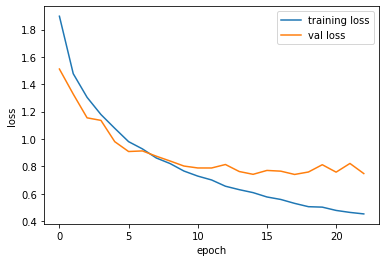

In [ ]:
plt.plot(trainingloss_1_1['Unnamed: 0'], trainingloss_1_1['0'])
plt.plot(valloss_1_1['Unnamed: 0'], valloss_1_1['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp0_unchanged/loss.jpg')
plt.show()

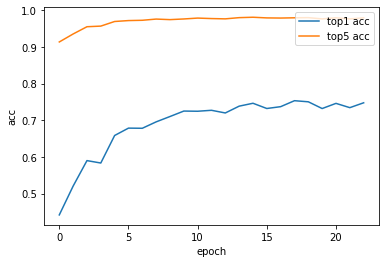

In [ ]:
plt.plot(valacc_1_1['Unnamed: 0'], valacc_1_1['0'])
plt.plot(valacc5_1_1['Unnamed: 0'], valacc5_1_1['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp0_unchanged/acc.jpg')
plt.show()

In [ ]:
model= torch.load('/content/drive/MyDrive/cv_pj/exp0_unchanged/epoch_17_accuracy_0.753500')
model.to(device)

AttributeError: ignored

In [ ]:
test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


#### 修改后alexnet

参数设置：
batch_size=128

model:alexnet

lr=0.001

criterion = nn.CrossEntropyLoss(size_average=True)

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epoch=90

对alexnet进行修改，让适应32*32的图片size
对于早期的模型也有所修改，去掉了LRN

In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
train_batch_size=128
test_batch_size=128
train_transform = transforms.Compose([ transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)



Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/changed_baseline/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/changed_baseline/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.095450
Epoch 0_51.200%:  Training average Loss: 1.944520
Epoch 0_76.800%:  Training average Loss: 1.831458
Epoch 0 :  Verification average Loss: 1.442393, Verification accuracy: 45.780000%,Total Time:43.919162
Epoch 0 :  Verification 5 accuracy: 92.280000%,Total Time:43.919301
Model is saved in /content/drive/MyDrive/cv_pj/changed_baseline/epoch_0_accuracy_0.457800
Epoch 1_25.600%:  Training average Loss: 1.409579
Epoch 1_51.200%:  Training average Loss: 1.379191
Epoch 1_76.800%:  Training average Loss: 1.347218
Epoch 1 :  Verification average Loss: 1.229264, Verification accuracy: 55.580000%,Total Time:88.313372
Epoch 1 :  Verification 5 accuracy: 94.290000%,Total Time:88.314438
Model is saved in /content/drive/MyDrive/cv_pj/changed_baseline/epoch_1_accuracy_0.555800
Epoch 2_25.600%:  Training average Loss: 1.197849
Epoch 2_51.200%:  Training average Loss: 1.179543
Epoch 2_76.800%:  Training average Loss: 1.168547
Epoch 2 :  Verification aver

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valacc5.csv',encoding='utf-8')

##### 修改后的alexnet可视化


In [ ]:

trainingloss_1_1 = pd.read_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_trainingloss.csv', encoding="utf-8")
valloss_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valloss.csv', encoding="utf-8")
valacc_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valacc.csv',encoding='utf-8')
valacc5_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/changed_baseline/changed_valacc5.csv',encoding='utf-8')

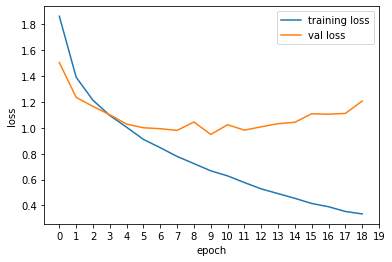

In [ ]:
plt.plot(trainingloss_1_1['Unnamed: 0'], trainingloss_1_1['0'])
plt.plot(valloss_1_1['Unnamed: 0'], valloss_1_1['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/changed_baseline/loss.jpg')
plt.show()

In [ ]:
plt.plot(valacc_1_1['Unnamed: 0'], valacc_1_1['0'])
plt.plot(valacc5_1_1['Unnamed: 0'], valacc5_1_1['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/changed_baseline/acc.jpg')
plt.show()

###实验一：验证不同学习率对网络的影响

#### learning rate: 0.001

In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp1_0.001/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.001/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.083878
Epoch 0_51.200%:  Training average Loss: 1.922369
Epoch 0_76.800%:  Training average Loss: 1.822722
Epoch 0 :  Verification average Loss: 1.402515, Verification accuracy: 47.250000%,Total Time:43.658756
Epoch 0 :  Verification 5 accuracy: 92.330000%,Total Time:43.658887
Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.001/epoch_0_accuracy_0.472500
Epoch 1_25.600%:  Training average Loss: 1.414019
Epoch 1_51.200%:  Training average Loss: 1.392659
Epoch 1_76.800%:  Training average Loss: 1.377384
Epoch 1 :  Verification average Loss: 1.258551, Verification accuracy: 54.640000%,Total Time:87.660764
Epoch 1 :  Verification 5 accuracy: 94.390000%,Total Time:87.662286
Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.001/epoch_1_accuracy_0.546400
Epoch 2_25.600%:  Training average Loss: 1.180407
Epoch 2_51.200%:  Training average Loss: 1.176908
Epoch 2_76.800%:  Training average Loss: 1.164336
Epoch 2 :  Verification average Loss: 1.

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valacc5.csv',encoding='utf-8')

In [ ]:
changed_trainingloss

,0
0,1.754774
1,1.349559
2,1.152008
3,1.035894
4,0.923878
5,0.839928
6,0.764660
7,0.693038
8,0.622788
9,0.567595


#### learning rate: 0.0001

In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.0001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp1_0.0001/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.0001/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.182466
Epoch 0_51.200%:  Training average Loss: 2.059424
Epoch 0 :  Verification average Loss: 1.640743, Verification accuracy: 38.790000%,Total Time:43.452954
Epoch 0 :  Verification 5 accuracy: 88.810000%,Total Time:43.453106
Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.0001/epoch_0_accuracy_0.387900
Epoch 1_25.600%:  Training average Loss: 1.553932
Epoch 1_51.200%:  Training average Loss: 1.526629
Epoch 1_76.800%:  Training average Loss: 1.498086
Epoch 1 :  Verification average Loss: 1.374148, Verification accuracy: 48.610000%,Total Time:87.159627
Epoch 1 :  Verification 5 accuracy: 93.410000%,Total Time:87.159765
Model is saved in /content/drive/MyDrive/cv_pj/exp1_0.0001/epoch_1_accuracy_0.486100
Epoch 2_25.600%:  Training average Loss: 1.356269
Epoch 2_51.200%:  Training average Loss: 1.331512
Epoch 2_76.800%:  Training average Loss: 1.324763
Epoch 2 :  Verification average Loss: 1.274263, Verification accuracy: 54.200000%,Total 

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valacc5.csv',encoding='utf-8')

#### 采用mulsetplr 即先0.001 训练，训练10个周期以后，再0.0001训练

In [ ]:
train_batch_size=128
test_batch_size=128
train_transform = transforms.Compose([ transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp1_changerate/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp1_changerate/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.096721
Epoch 0_51.200%:  Training average Loss: 1.946025
Epoch 0_76.800%:  Training average Loss: 1.851379
Epoch 0 :  Verification average Loss: 1.481461, Verification accuracy: 43.960000%,Total Time:40.952145
Epoch 0 :  Verification 5 accuracy: 91.580000%,Total Time:40.953307
Model is saved in /content/drive/MyDrive/cv_pj/exp1_changerate/epoch_0_accuracy_0.439600
Epoch 1_25.600%:  Training average Loss: 1.482522
Epoch 1_51.200%:  Training average Loss: 1.436518
Epoch 1_76.800%:  Training average Loss: 1.401186
Epoch 1 :  Verification average Loss: 1.235519, Verification accuracy: 55.070000%,Total Time:82.466196
Epoch 1 :  Verification 5 accuracy: 94.520000%,Total Time:82.466331
Model is saved in /content/drive/MyDrive/cv_pj/exp1_changerate/epoch_1_accuracy_0.550700
Epoch 2_25.600%:  Training average Loss: 1.230302
Epoch 2_51.200%:  Training average Loss: 1.221048
Epoch 2_76.800%:  Training average Loss: 1.202384
Epoch 2 :  Verification averag

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valacc5.csv',encoding='utf-8')

#### 对实验一进行结果可视化

#### 0.001可视化

In [ ]:

trainingloss_1_1 = pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/trainingloss.csv', encoding="utf-8")
valloss_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valloss.csv', encoding="utf-8")
valacc_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valacc.csv',encoding='utf-8')
valacc5_1_1=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.001/valacc5.csv',encoding='utf-8')




In [ ]:
trainingloss_1_1.columns.values.tolist()

##### loss fig


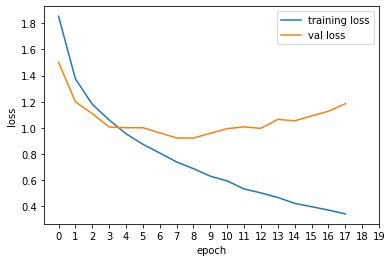

In [ ]:
plt.plot(trainingloss_1_1['Unnamed: 0'], trainingloss_1_1['0'])
plt.plot(valloss_1_1['Unnamed: 0'], valloss_1_1['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.001/loss.jpg')
plt.show()

##### acc fig

In [ ]:
plt.plot(valacc_1_1['Unnamed: 0'], valacc_1_1['0'])
plt.plot(valacc5_1_1['Unnamed: 0'], valacc5_1_1['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.001/acc.jpg')
plt.show()

##### 模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp1_0.001/epoch_12_accuracy_0.704000")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7055398609887351 0.704
accuracy:0.704
precision:0.704
recall:0.704
f1-score:0.704
f1-score:0.7055398609887351


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


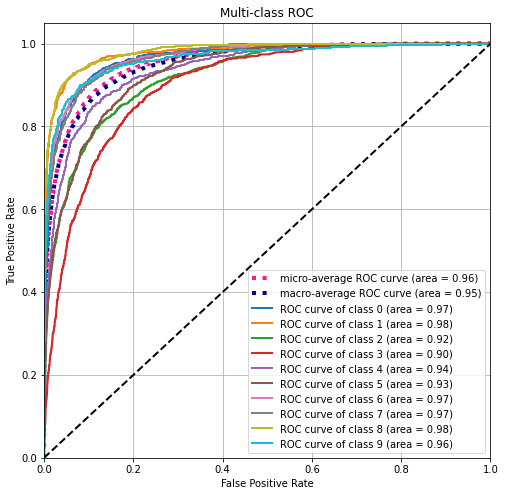

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.001/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### 0.0001可视化

In [ ]:

trainingloss_1_2 = pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/trainingloss.csv', encoding="utf-8")
valloss_1_2=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valloss.csv', encoding="utf-8")
valacc_1_2=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valacc.csv',encoding='utf-8')
valacc5_1_2=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_0.0001/valacc5.csv',encoding='utf-8')


##### loss fig

In [ ]:
plt.plot(trainingloss_1_2['Unnamed: 0'], trainingloss_1_2['0'])
plt.plot(valloss_1_2['Unnamed: 0'], valloss_1_2['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.0001/loss.jpg')
plt.show()

##### acc fig


In [ ]:
plt.plot(valacc_1_2['Unnamed: 0'], valacc_1_2['0'])
plt.plot(valacc5_1_2['Unnamed: 0'], valacc5_1_2['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.0001/acc.jpg')
plt.show()

##### 模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp1_0.0001/epoch_19_accuracy_0.706000")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7046611330633143 0.706
accuracy:0.706
precision:0.706
recall:0.706
f1-score:0.706
f1-score:0.7046611330633143


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


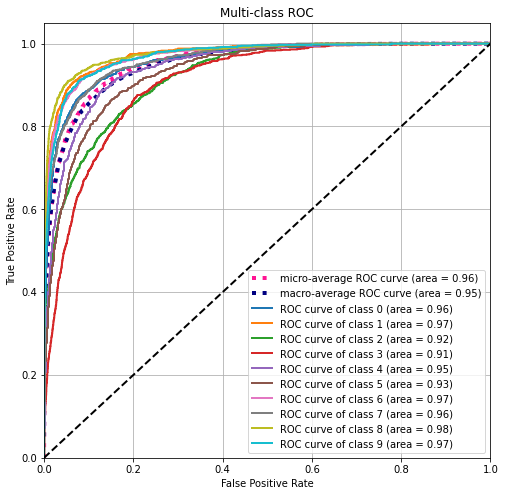

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_0.0001/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### changerate

In [ ]:
trainingloss_1_3 = pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/trainingloss.csv',encoding='utf-8')
valloss_1_3=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valloss.csv',encoding='utf-8')
valacc_1_3=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valacc.csv',encoding='utf-8')
valacc5_1_3=pd.read_csv('/content/drive/MyDrive/cv_pj/exp1_changerate/valacc5.csv',encoding='utf-8')


##### loss

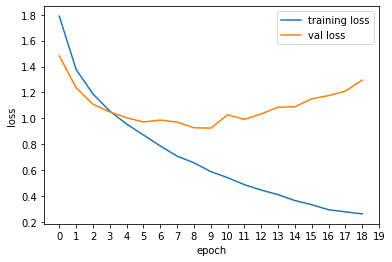

In [ ]:
plt.plot(trainingloss_1_3['Unnamed: 0'], trainingloss_1_3['0'])
plt.plot(valloss_1_3['Unnamed: 0'], valloss_1_3['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_changerate/loss.jpg')
plt.show()

##### acc


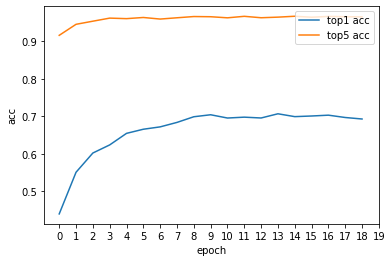

In [ ]:
plt.plot(valacc_1_3['Unnamed: 0'], valacc_1_3['0'])
plt.plot(valacc5_1_3['Unnamed: 0'], valacc5_1_3['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_changerate/acc.jpg')
plt.show()

##### 模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp1_changerate/epoch_13_accuracy_0.706600")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7059872796624934 0.7066
accuracy:0.7066
precision:0.7066
recall:0.7066
f1-score:0.7066
f1-score:0.7059872796624934


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


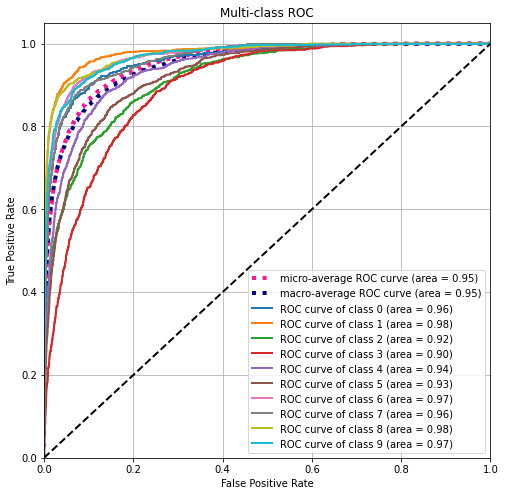

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_changerate/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### 实验一纵向比较
由于采用了early stopping，所以收敛速度可视化机制可能不够好看。此外，由于top5正确率太高，不方便比较，因此仅仅比较top1正确率

##### acc 比较

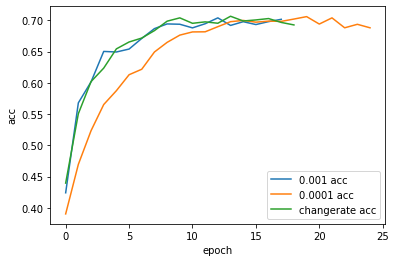

In [ ]:
plt.plot(valacc_1_1['Unnamed: 0'], valacc_1_1['0'])
plt.plot(valacc_1_2['Unnamed: 0'], valacc_1_2['0'])
plt.plot(valacc_1_3['Unnamed: 0'], valacc_1_3['0'])
#plt.plot(valacc5_1_3['Unnamed: 0'], valacc5_1_3['0'])
plt.legend(['0.001 acc', '0.0001 acc','changerate acc'], loc=4)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 30, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_fig/acc.jpg')
plt.show()

##### loss 比较

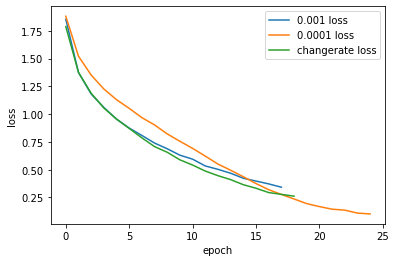

In [ ]:
plt.plot(trainingloss_1_1['Unnamed: 0'], trainingloss_1_1['0'])
plt.plot(trainingloss_1_2['Unnamed: 0'], trainingloss_1_2['0'])
plt.plot(trainingloss_1_3['Unnamed: 0'], trainingloss_1_3['0'])
plt.legend(['0.001 loss', '0.0001 loss','changerate loss'], loc=1)
#plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 30, 5)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp1_fig/loss.jpg')
plt.show()

### 实验二：数据集增强

#### 数据集baseline

In [ ]:
train_batch_size=128
test_batch_size=128
#transforms.RandomHorizontalFlip(), 
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp2_base/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp2_base/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.115165
Epoch 0_51.200%:  Training average Loss: 1.950044
Epoch 0_76.800%:  Training average Loss: 1.842006
Epoch 0 :  Verification average Loss: 1.448061, Verification accuracy: 45.750000%,Total Time:41.094825
Epoch 0 :  Verification 5 accuracy: 92.270000%,Total Time:41.095676
Model is saved in /content/drive/MyDrive/cv_pj/exp2_base/epoch_0_accuracy_0.457500
Epoch 1_25.600%:  Training average Loss: 1.439530
Epoch 1_51.200%:  Training average Loss: 1.417456
Epoch 1_76.800%:  Training average Loss: 1.391748
Epoch 1 :  Verification average Loss: 1.265946, Verification accuracy: 54.890000%,Total Time:82.375044
Epoch 1 :  Verification 5 accuracy: 94.060000%,Total Time:82.375179
Model is saved in /content/drive/MyDrive/cv_pj/exp2_base/epoch_1_accuracy_0.548900
Epoch 2_25.600%:  Training average Loss: 1.245849
Epoch 2_51.200%:  Training average Loss: 1.216142
Epoch 2_76.800%:  Training average Loss: 1.198018
Epoch 2 :  Verification average Loss: 1.08

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp2_base/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp2_base/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp2_base/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp2_base/valacc5.csv',encoding='utf-8')

#####  可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_base/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_base/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_base/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_base/valacc5.csv',encoding='utf-8')

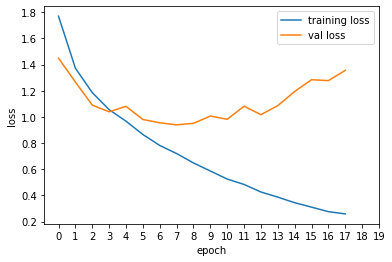

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_base/loss.jpg')
plt.show()

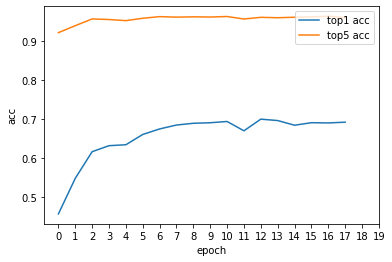

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_base/acc.jpg')
plt.show()

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp2_base/epoch_12_accuracy_0.700700")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7002448583805971 0.7007
accuracy:0.7007
precision:0.7007
recall:0.7007
f1-score:0.7007
f1-score:0.7002448583805971


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


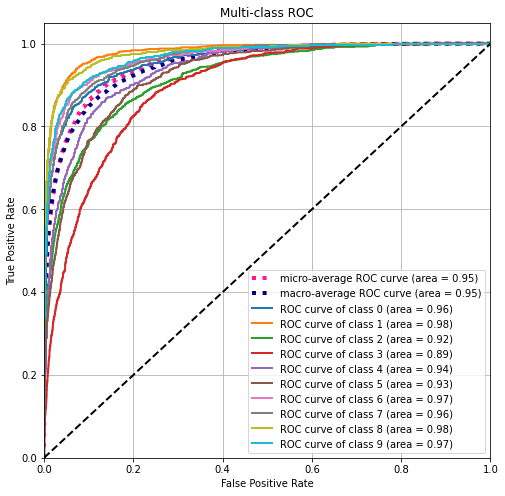

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_base/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### 进行数据集加强

对于训练集，padding=4为上下左右均填充 4 个 pixel，由32×32的尺寸变为40×40，之后进行任意的裁剪；接着以0.5的概率进行水平翻转。将图像转化为tensor对象，并进行正态分布标准化。
对于测试集，不进行增强操作，仅仅对图像转化为tensor对象，并进行正态分布标准化，标准化的值与训练集相同。




In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp2_aug/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp2_aug/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.106257
Epoch 0_51.200%:  Training average Loss: 1.947967
Epoch 0_76.800%:  Training average Loss: 1.860547
Epoch 0 :  Verification average Loss: 1.465062, Verification accuracy: 45.250000%,Total Time:54.692660
Epoch 0 :  Verification 5 accuracy: 92.000000%,Total Time:54.692806
Model is saved in /content/drive/MyDrive/cv_pj/exp2_aug/epoch_0_accuracy_0.452500
Epoch 1_25.600%:  Training average Loss: 1.531578
Epoch 1_51.200%:  Training average Loss: 1.506773
Epoch 1_76.800%:  Training average Loss: 1.478341
Epoch 1 :  Verification average Loss: 1.323382, Verification accuracy: 52.240000%,Total Time:110.170722
Epoch 1 :  Verification 5 accuracy: 93.600000%,Total Time:110.170904
Model is saved in /content/drive/MyDrive/cv_pj/exp2_aug/epoch_1_accuracy_0.522400
Epoch 2_25.600%:  Training average Loss: 1.356309
Epoch 2_51.200%:  Training average Loss: 1.345424
Epoch 2_76.800%:  Training average Loss: 1.329961
Epoch 2 :  Verification average Loss: 1.22

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp2_aug/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valacc5.csv',encoding='utf-8')

##### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_aug/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp2_aug/valacc5.csv',encoding='utf-8')

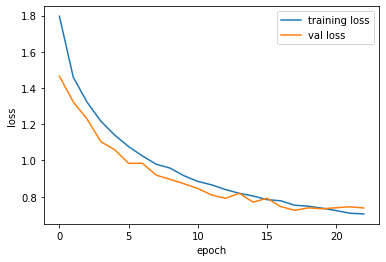

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_aug/loss.jpg')
plt.show()

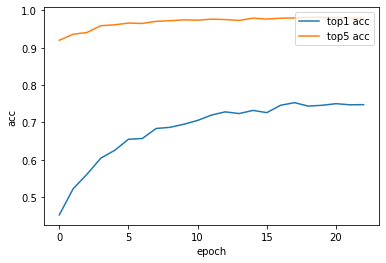

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_aug/acc.jpg')
plt.show()

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp2_aug/epoch_17_accuracy_0.752900")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.752046194671463 0.7529
accuracy:0.7529
precision:0.7529
recall:0.7529
f1-score:0.7529
f1-score:0.752046194671463


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


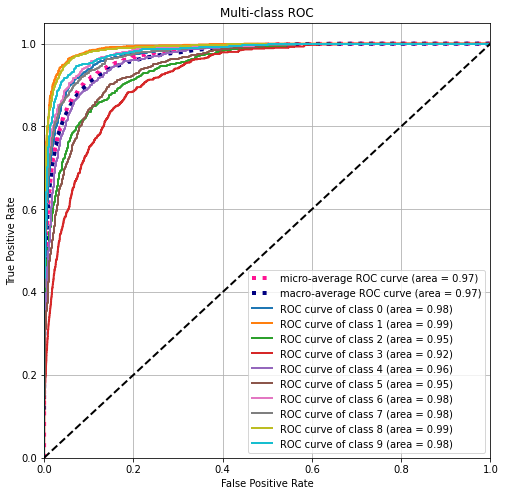

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp2_aug/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


### 实验三：加上LRN 

正确率估计不会有很大的提高，但是可以比对运行时间
和实验二的数据集增强对比同周期数运行时间

##### 实验

In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)


Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), #0.2.0_4会报错，需要在最新的分支上AvgPool3d才有padding参数
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)#这里的1.0即为bias
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x


In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp3/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp3/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.117486
Epoch 0_51.200%:  Training average Loss: 1.971403
Epoch 0_76.800%:  Training average Loss: 1.881350
Epoch 0 :  Verification average Loss: 1.550517, Verification accuracy: 41.400000%,Total Time:58.663740
Epoch 0 :  Verification 5 accuracy: 90.740000%,Total Time:58.663887
Model is saved in /content/drive/MyDrive/cv_pj/exp3/epoch_0_accuracy_0.414000
Epoch 1_25.600%:  Training average Loss: 1.547563
Epoch 1_51.200%:  Training average Loss: 1.516223
Epoch 1_76.800%:  Training average Loss: 1.494561
Epoch 1 :  Verification average Loss: 1.274495, Verification accuracy: 52.730000%,Total Time:117.614049
Epoch 1 :  Verification 5 accuracy: 94.300000%,Total Time:117.614188
Model is saved in /content/drive/MyDrive/cv_pj/exp3/epoch_1_accuracy_0.527300
Epoch 2_25.600%:  Training average Loss: 1.362601
Epoch 2_51.200%:  Training average Loss: 1.341798
Epoch 2_76.800%:  Training average Loss: 1.327039
Epoch 2 :  Verification average Loss: 1.201034, Ve

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp3/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp3/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp3/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp3/valacc5.csv',encoding='utf-8')

##### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp3/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp3/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp3/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp3/valacc5.csv',encoding='utf-8')

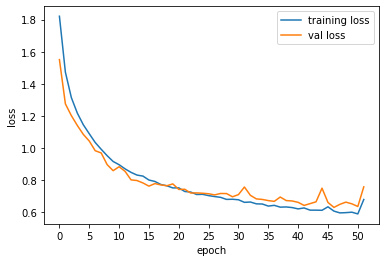

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 55, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp3/loss.jpg')
plt.show()

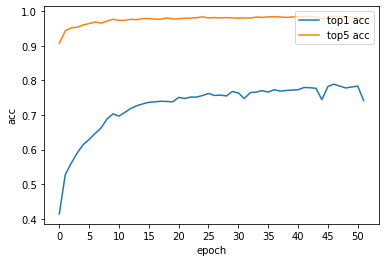

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 55, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp3/acc.jpg')
plt.show()

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp3/epoch_46_accuracy_0.788900")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LRN(
      (average): AvgPool3d(kernel_size=(5, 1, 1), stride=1, padding=(2, 0, 0))
    )
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7885777442184325 0.7889
accuracy:0.7889
precision:0.7889
recall:0.7889
f1-score:0.7889
f1-score:0.7885777442184325


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


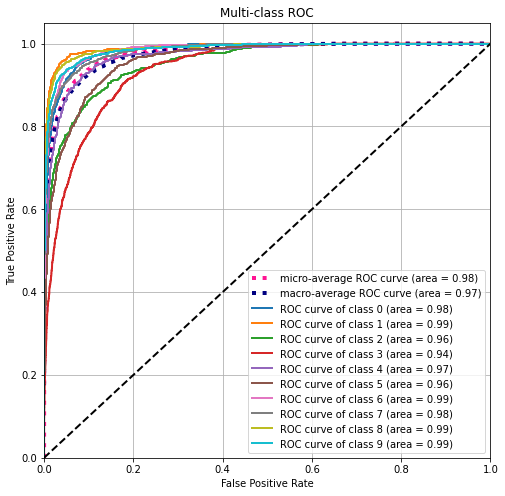

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp3/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


### 实验四：更换优化器

实验结果没有本质差别

### 实验五：改变Dropout


#### dropout=0.5

In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp5_0.5/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.5/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.052625
Epoch 0_51.200%:  Training average Loss: 1.920003
Epoch 0_76.800%:  Training average Loss: 1.823802
Epoch 0 :  Verification average Loss: 1.549494, Verification accuracy: 41.870000%,Total Time:19.482666
Epoch 0 :  Verification 5 accuracy: 90.490000%,Total Time:19.482786
Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.5/epoch_0_accuracy_0.418700
Epoch 1_25.600%:  Training average Loss: 1.517455
Epoch 1_51.200%:  Training average Loss: 1.485845
Epoch 1_76.800%:  Training average Loss: 1.460785
Epoch 1 :  Verification average Loss: 1.308360, Verification accuracy: 52.950000%,Total Time:39.711505
Epoch 1 :  Verification 5 accuracy: 93.810000%,Total Time:39.711624
Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.5/epoch_1_accuracy_0.529500
Epoch 2_25.600%:  Training average Loss: 1.336038
Epoch 2_51.200%:  Training average Loss: 1.337411
Epoch 2_76.800%:  Training average Loss: 1.322145
Epoch 2 :  Verification average Loss: 1.2365

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valacc5.csv',encoding='utf-8')

###### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valacc5.csv',encoding='utf-8')

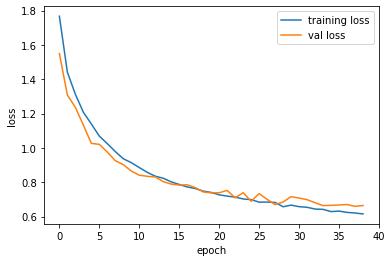

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.5/loss.jpg')
plt.show()

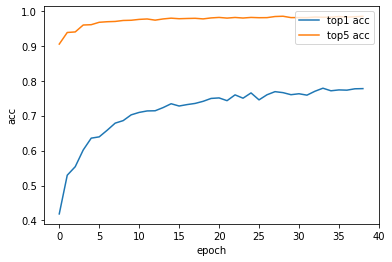

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.5/acc.jpg')
plt.show()

###### 模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp5_0.5/epoch_33_accuracy_0.778600")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7764761311515549 0.7786
accuracy:0.7786
precision:0.7786
recall:0.7786
f1-score:0.7786
f1-score:0.7764761311515549


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


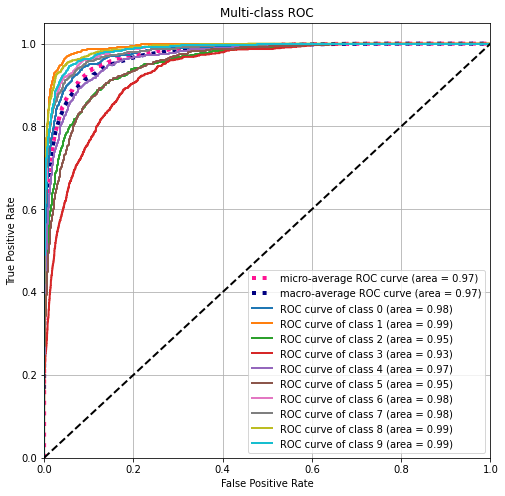

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.5/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### dropout=0.9

###### 实验

In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.9),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.9, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.9, in

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp5_0.9/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.9/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.268930
Epoch 0_51.200%:  Training average Loss: 2.135791
Epoch 0_76.800%:  Training average Loss: 2.053680
Epoch 0 :  Verification average Loss: 1.637221, Verification accuracy: 34.200000%,Total Time:20.122686
Epoch 0 :  Verification 5 accuracy: 89.210000%,Total Time:20.122805
Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.9/epoch_0_accuracy_0.342000
Epoch 1_25.600%:  Training average Loss: 1.742351
Epoch 1_51.200%:  Training average Loss: 1.718241
Epoch 1_76.800%:  Training average Loss: 1.696019
Epoch 1 :  Verification average Loss: 1.492760, Verification accuracy: 42.810000%,Total Time:41.102754
Epoch 1 :  Verification 5 accuracy: 91.810000%,Total Time:41.102886
Model is saved in /content/drive/MyDrive/cv_pj/exp5_0.9/epoch_1_accuracy_0.428100
Epoch 2_25.600%:  Training average Loss: 1.591920
Epoch 2_51.200%:  Training average Loss: 1.576009
Epoch 2_76.800%:  Training average Loss: 1.565550
Epoch 2 :  Verification average Loss: 1.3880

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valacc5.csv',encoding='utf-8')

##### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valacc5.csv',encoding='utf-8')

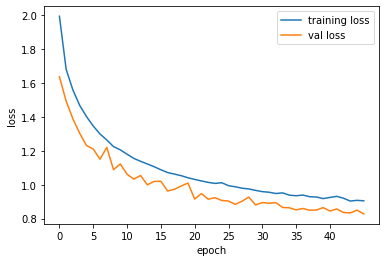

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.9/loss.jpg')
plt.show()

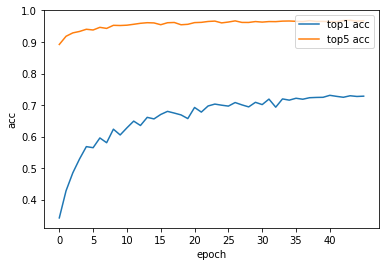

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.9/acc.jpg')
plt.show()

##### 模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp5_0.9/epoch_40_accuracy_0.730800")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.9, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.9, in

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7322203089215548 0.7308
accuracy:0.7308
precision:0.7308
recall:0.7308
f1-score:0.7308
f1-score:0.7322203089215548


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


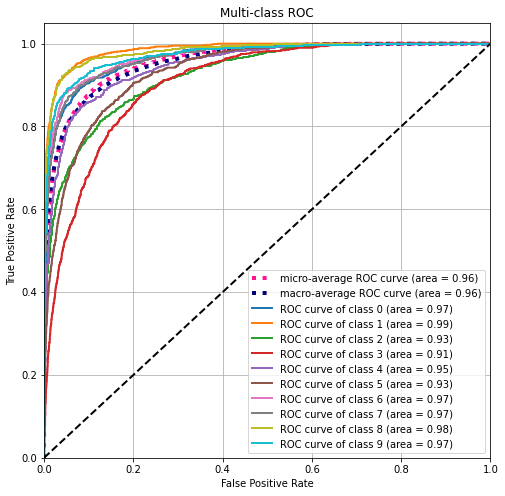

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_0.9/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


#### 比对图

In [ ]:
valloss5 = pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valloss.csv',encoding='utf-8')
valloss9=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valloss.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.5/valacc.csv',encoding='utf-8')
valacc9=pd.read_csv('/content/drive/MyDrive/cv_pj/exp5_0.9/valacc.csv',encoding='utf-8')

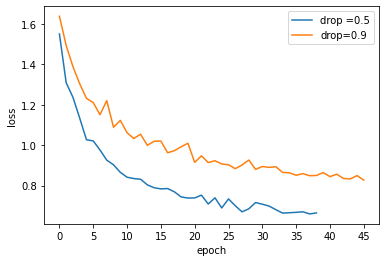

In [ ]:
plt.plot(valloss5['Unnamed: 0'], valloss5['0'])
plt.plot(valloss9['Unnamed: 0'], valloss9['0'])
#plt.plot(valacc_1_3['Unnamed: 0'], valacc_1_3['0'])
#plt.plot(valacc5_1_3['Unnamed: 0'], valacc5_1_3['0'])
plt.legend(['drop =0.5', 'drop=0.9'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 50, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_fig/loss.jpg')
plt.show()

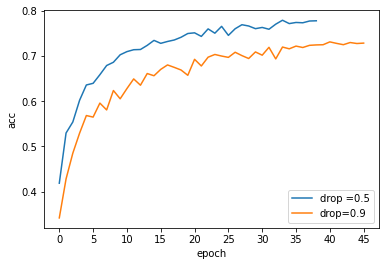

In [ ]:
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.plot(valacc9['Unnamed: 0'], valacc9['0'])
#plt.plot(valacc_1_3['Unnamed: 0'], valacc_1_3['0'])
#plt.plot(valacc5_1_3['Unnamed: 0'], valacc5_1_3['0'])
plt.legend(['drop =0.5', 'drop=0.9'], loc=4)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 50, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp5_fig/acc.jpg')
plt.show()

### 实验六：尝试不同的初始化

由于官方的初始化方式，已经应用到合适的初始化方式。使用自定义初始化方式，容易梯度为0或梯度爆炸

### 实验七：加上BN层

注意，这个实验结果是最好的

##### 实验


In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.9),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(2

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp7/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp7/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.706545
Epoch 0_51.200%:  Training average Loss: 2.401070
Epoch 0_76.800%:  Training average Loss: 2.259757
Epoch 0 :  Verification average Loss: 1.915625, Verification accuracy: 23.790000%,Total Time:20.370970
Epoch 0 :  Verification 5 accuracy: 81.120000%,Total Time:20.371084
Model is saved in /content/drive/MyDrive/cv_pj/exp7/epoch_0_accuracy_0.237900
Epoch 1_25.600%:  Training average Loss: 1.858865
Epoch 1_51.200%:  Training average Loss: 1.827466
Epoch 1_76.800%:  Training average Loss: 1.795368
Epoch 1 :  Verification average Loss: 1.591941, Verification accuracy: 37.530000%,Total Time:41.952124
Epoch 1 :  Verification 5 accuracy: 90.780000%,Total Time:41.952236
Model is saved in /content/drive/MyDrive/cv_pj/exp7/epoch_1_accuracy_0.375300
Epoch 2_25.600%:  Training average Loss: 1.626184
Epoch 2_51.200%:  Training average Loss: 1.602144
Epoch 2_76.800%:  Training average Loss: 1.580578
Epoch 2 :  Verification average Loss: 1.357090, Veri

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp7/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp7/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp7/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp7/valacc5.csv',encoding='utf-8')

##### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp7/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp7/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp7/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp7/valacc5.csv',encoding='utf-8')

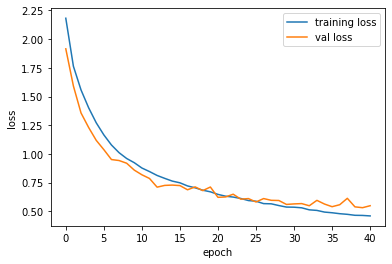

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp7/loss.jpg')
plt.show()

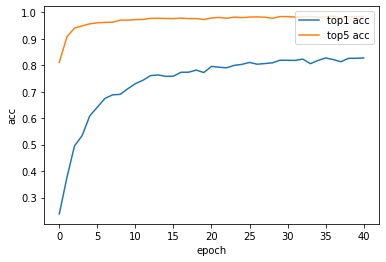

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 45, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp7/acc.jpg')
plt.show()

##### 最优模型可视化

In [ ]:
model= torch.load("/content/drive/MyDrive/cv_pj/exp7/epoch_35_accuracy_0.828000")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(2

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.8293479665260086 0.828
accuracy:0.828
precision:0.828
recall:0.828
f1-score:0.828
f1-score:0.8293479665260086


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


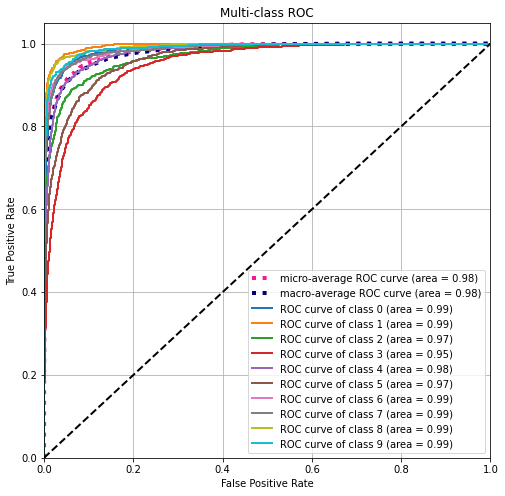

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp8/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


### 实验八：使用global average pooling代替fc

##### 训练

In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)


Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
NUM_CLASSES = 10

#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 10,kernel_size=1),
            nn.AvgPool2d(2, stride=1)
                      
        )
      

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 10)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
    (14): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Avg

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp8/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp8/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 1.989978
Epoch 0_51.200%:  Training average Loss: 1.828241
Epoch 0_76.800%:  Training average Loss: 1.729887
Epoch 0 :  Verification average Loss: 1.368453, Verification accuracy: 50.100000%,Total Time:16.847470
Epoch 0 :  Verification 5 accuracy: 93.340000%,Total Time:16.847581
Model is saved in /content/drive/MyDrive/cv_pj/exp8/epoch_0_accuracy_0.501000
Epoch 1_25.600%:  Training average Loss: 1.355744
Epoch 1_51.200%:  Training average Loss: 1.340566
Epoch 1_76.800%:  Training average Loss: 1.320114
Epoch 1 :  Verification average Loss: 1.178826, Verification accuracy: 57.150000%,Total Time:33.988860
Epoch 1 :  Verification 5 accuracy: 95.170000%,Total Time:33.988969
Model is saved in /content/drive/MyDrive/cv_pj/exp8/epoch_1_accuracy_0.571500
Epoch 2_25.600%:  Training average Loss: 1.164493
Epoch 2_51.200%:  Training average Loss: 1.155544
Epoch 2_76.800%:  Training average Loss: 1.139753
Epoch 2 :  Verification average Loss: 1.029977, Veri

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp8/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp8/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp8/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp8/valacc5.csv',encoding='utf-8')

##### 可视化

In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp8/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp8/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp8/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp8/valacc5.csv',encoding='utf-8')

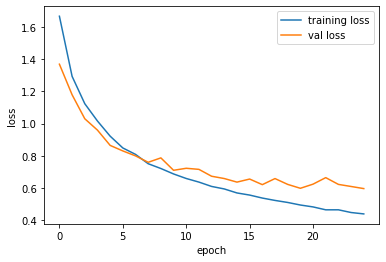

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp8/loss.jpg')
plt.show()

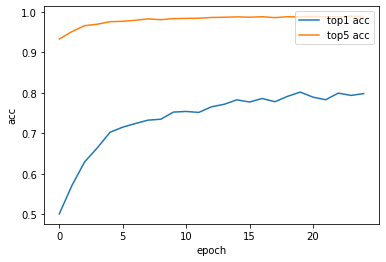

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp8/acc.jpg')
plt.show()

##### 最优模型可视化

In [ ]:
model= torch.load('/content/drive/MyDrive/cv_pj/exp8/epoch_19_accuracy_0.802100')
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
    (14): AvgPool2d(kernel_size=2, stride=1, padding=0)
  )
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): Avg

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.7995173092880137 0.8021000000000001
accuracy:0.8021
precision:0.8021
recall:0.8021
f1-score:0.8021000000000001
f1-score:0.7995173092880137


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


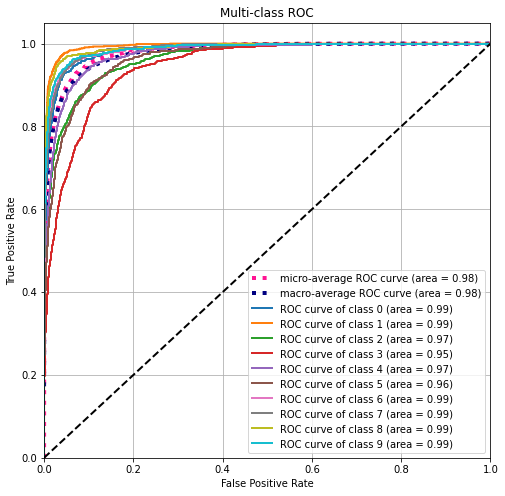

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp8/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()


### 实验九：对模型的一点修改
用sebolck进行模型增强


In [ ]:
train_batch_size=128
test_batch_size=128
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])

test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
train_set = torchvision.datasets.CIFAR10(root='cifar', train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class SEblock(nn.Module):
    def __init__(self,input_channel: int, r: int = 16):
        super(SEblock, self).__init__()
        self.avgPool_glb = nn.AdaptiveAvgPool2d((1,1)) # C * H * W -> C
        self.fc1 = nn.Linear(input_channel , input_channel//r) # 降维
        self.fc2 = nn.Linear( input_channel//r ,input_channel) # 生维
        return

    def forward(self,x):
        # x : [BatchSize * C * H * W]
        # squeeze
        z = self.avgPool_glb(x) # [BS * C ]
        # excitation
        z = z.squeeze(-1).squeeze(-1)
        z =F.relu(self.fc1(z))  # [BS * C/r]
        z = torch.sigmoid(self.fc2(z)) # [BS * C ]
        # rescaling
        output = torch.einsum('ajbc,aj->ajbc ', x, z) # [B , C , H, W]
        return output

In [ ]:
NUM_CLASSES = 10
#we modifiesd the net to fit the datasize
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            SEblock(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            SEblock(192),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet(10)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SEblock(
      (avgPool_glb): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): SEblock(
      (avgPool_glb): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=192, out_features=12, bias=True)
      (fc2): Linear(in_features=12, out_features=192, bias=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2

In [ ]:
lr=0.001
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
changed_trainingloss=[]
changed_valloss=[]
changed_valacc=[]
changed_valacc5=[]

In [ ]:
import time
epoch=90
es=0.0
best_accuracy=0.0
start_time=time.time()
for i in range(epoch):
    model.train()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_data_num = len(train_dataloader.dataset)
    steps = 0.0
    #训练
    for batch in train_dataloader:
        steps+=1
        optimizer.zero_grad() 
        # 取数据
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        #_, outputs = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = criterion(outputs, labels).to(device)

        loss.backward()
        optimizer.step()  

        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()

        if steps%100==0:
            print("Epoch %d_%.3f%%:  Training average Loss: %f"
                      %(i, steps * train_dataloader.batch_size*100/len(train_dataloader.dataset),total_loss/steps))  
    changed_trainingloss.append(total_loss/steps)
    #验证
    model.eval()
    total_loss=0.0
    accuracy=0.0
    total_correct=0.0
    total_correctk=0.0
    total_data_num = len(dev_dataloader.dataset)
    steps = 0.0    
    for batch in dev_dataloader:
        steps+=1
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)  
        total_loss = total_loss + loss.item() 
        correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   .view(labels.size()) == labels).sum()
        total_correct = total_correct + correct.item()
        #print('accuracy:{}'.format(accuracy_score(labels, y_score)))
        #print('precision:{}'.format(precision_score(labels, y_score,average='micro')))
        #print('recall:{}'.format(recall_score(labels, y_score,average='micro')))
        #print('f1-score:{}'.format(f1_score(labels, y_score,average='micro'))

        maxk = max((1,5))
        yresize = labels.view(-1,1)
        _, pred = outputs.topk(maxk, 1, True, True)

        correctk = torch.eq(pred, yresize).sum()

        #correct = (torch.max(outputs, dim=1)[1]  #get the indices
                   #.view(labels.size()) == labels).sum()
        total_correctk = total_correctk + correctk.item()
        
    print("Epoch %d :  Verification average Loss: %f, Verification accuracy: %f%%,Total Time:%f"
      %(i, total_loss/steps, total_correct*100/total_data_num,time.time()-start_time))  
    print("Epoch %d :  Verification 5 accuracy: %f%%,Total Time:%f"
      %(i,  total_correctk*100/total_data_num,time.time()-start_time))  
    changed_valloss.append(total_loss/steps)
    changed_valacc.append(total_correct/total_data_num) 
    changed_valacc5.append(total_correctk/total_data_num) 
    if best_accuracy < total_correct/total_data_num :
        es=0
        best_accuracy =total_correct/total_data_num 
        torch.save(model,'/content/drive/MyDrive/cv_pj/exp9/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        print('Model is saved in /content/drive/MyDrive/cv_pj/exp9/epoch_%d_accuracy_%f'%(i,total_correct/total_data_num))
        #torch.cuda.empty_cache()
    else:
        es += 1
        print("Counter {} of 5".format(es))
        if es > 4:
            print("Early stopping with best_acc: ", best_accuracy, "and val_acc for this epoch: ", total_correct/total_data_num, "...")
            break

Epoch 0_25.600%:  Training average Loss: 2.010331
Epoch 0_51.200%:  Training average Loss: 1.865941
Epoch 0_76.800%:  Training average Loss: 1.772612
Epoch 0 :  Verification average Loss: 1.367102, Verification accuracy: 50.120000%,Total Time:19.744518
Epoch 0 :  Verification 5 accuracy: 93.090000%,Total Time:19.744641
Model is saved in /content/drive/MyDrive/cv_pj/exp9/epoch_0_accuracy_0.501200
Epoch 1_25.600%:  Training average Loss: 1.421092
Epoch 1_51.200%:  Training average Loss: 1.389085
Epoch 1_76.800%:  Training average Loss: 1.356126
Epoch 1 :  Verification average Loss: 1.236092, Verification accuracy: 56.670000%,Total Time:40.426102
Epoch 1 :  Verification 5 accuracy: 94.500000%,Total Time:40.426212
Model is saved in /content/drive/MyDrive/cv_pj/exp9/epoch_1_accuracy_0.566700
Epoch 2_25.600%:  Training average Loss: 1.215352
Epoch 2_51.200%:  Training average Loss: 1.179362
Epoch 2_76.800%:  Training average Loss: 1.159987
Epoch 2 :  Verification average Loss: 1.055127, Veri

In [ ]:
changed_trainingloss=pd.DataFrame(data=changed_trainingloss)
changed_trainingloss.to_csv('/content/drive/MyDrive/cv_pj/exp9/trainingloss.csv',encoding='utf-8')

changed_valloss=pd.DataFrame(data=changed_valloss)
changed_valloss.to_csv('/content/drive/MyDrive/cv_pj/exp9/valloss.csv',encoding='utf-8')

changed_valacc=pd.DataFrame(data=changed_valacc)
changed_valacc.to_csv('/content/drive/MyDrive/cv_pj/exp9/valacc.csv',encoding='utf-8')

changed_valacc5=pd.DataFrame(data=changed_valacc5)
changed_valacc5.to_csv('/content/drive/MyDrive/cv_pj/exp9/valacc5.csv',encoding='utf-8')

##### 对模型进行可视化


In [ ]:
trainingloss = pd.read_csv('/content/drive/MyDrive/cv_pj/exp9/trainingloss.csv',encoding='utf-8')
valloss=pd.read_csv('/content/drive/MyDrive/cv_pj/exp9/valloss.csv',encoding='utf-8')
valacc=pd.read_csv('/content/drive/MyDrive/cv_pj/exp9/valacc.csv',encoding='utf-8')
valacc5=pd.read_csv('/content/drive/MyDrive/cv_pj/exp9/valacc5.csv',encoding='utf-8')

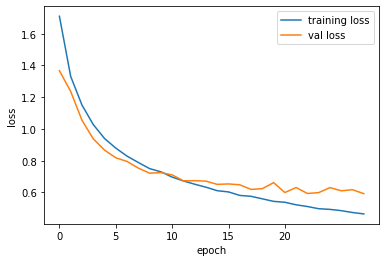

In [ ]:
plt.plot(trainingloss['Unnamed: 0'], trainingloss['0'])
plt.plot(valloss['Unnamed: 0'], valloss['0'])
plt.legend(['training loss', 'val loss'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('loss')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)

plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp9/loss.jpg')
plt.show()

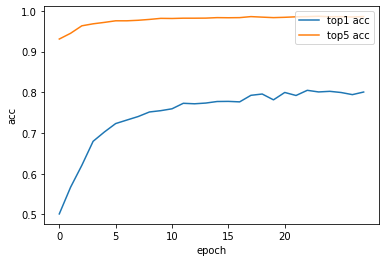

In [ ]:
plt.plot(valacc['Unnamed: 0'], valacc['0'])
plt.plot(valacc5['Unnamed: 0'], valacc5['0'])
plt.legend(['top1 acc', 'top5 acc'], loc=1)
#设置坐标轴名称
plt.xlabel('epoch')
plt.ylabel('acc')
#设置坐标轴刻度
my_x_ticks = np.arange(0, 25, 5)
plt.xticks(my_x_ticks)
#plt.title('exp1 0.001 loss') 
plt.savefig('/content/drive/MyDrive/cv_pj/exp9/acc.jpg')
plt.show()

##### 对模型进行检测

In [ ]:
model= torch.load('/content/drive/MyDrive/cv_pj/exp9/epoch_22_accuracy_0.804900')
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): SEblock(
      (avgPool_glb): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): SEblock(
      (avgPool_glb): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc1): Linear(in_features=192, out_features=12, bias=True)
      (fc2): Linear(in_features=12, out_features=192, bias=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2

In [ ]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_norm_mean, cifar_norm_std)])
test_set = torchvision.datasets.CIFAR10(root='cifar', train=False, download=True, transform=test_transform)
dev_dataloader = torch.utils.data.DataLoader(dataset=test_set, shuffle=False, batch_size=10000)

Files already downloaded and verified


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)
  _, pred = torch.max(outputs, 1)
  pred=pred.cpu().numpy()
  labels=labels.cpu().numpy()
  ma_f1 = f1_score(labels, pred, average='macro')
  mi_f1 = f1_score(labels, pred, average='micro')
  print(ma_f1, mi_f1)
  print('accuracy:{}'.format(accuracy_score(labels, pred)))
  print('precision:{}'.format(precision_score(labels, pred,average='micro')))
  print('recall:{}'.format(recall_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='micro')))
  print('f1-score:{}'.format(f1_score(labels, pred,average='macro')))


0.8044628583652566 0.8049
accuracy:0.8049
precision:0.8049
recall:0.8049
f1-score:0.8049
f1-score:0.8044628583652566


In [ ]:
for batch in dev_dataloader:
  steps+=1
  inputs, labels = batch
  inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
  outputs = model(inputs)


scores = torch.softmax(outputs, dim=1).detach().cpu().numpy() # out = model(data)
labels=labels.cpu().numpy()
binary_label = label_binarize(labels, classes=list(range(10))) # num_classes=10

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_label.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


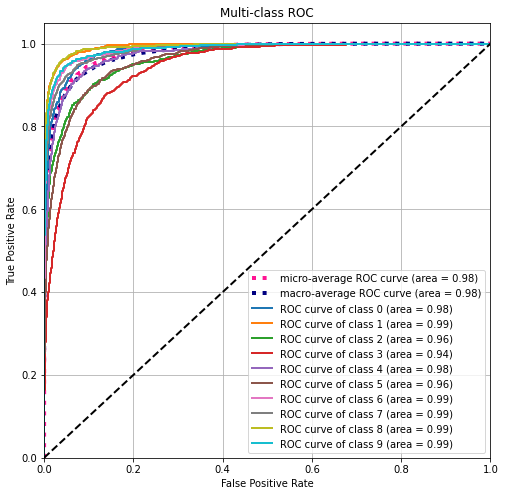

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/cv_pj/exp9/Multi-class ROC.jpg', bbox_inches='tight')
plt.show()
